In [1]:
import json
import pandas as pd
import seaborn as sns
import re
import pickle
# import mowl
# mowl.init_jvm("4g")
import networkx as nx
from networkx.readwrite import json_graph
import matplotlib.pyplot as plt

## Load depth graph


In [2]:
big_G = {}

def read_json_file(filename):
    with open(filename) as f:
        js_graph = json.load(f)
    return json_graph.node_link_graph(js_graph)

big_G = read_json_file("../../Data/Output/MeSH_graph_with_depth.json")

print(big_G.nodes["D004628"]["Depth"])

1


## Frequency analysis of MeSH terms in RELISH abstracts

We will load a json file that contains all the MeSH terms that are mentioned in pubmed abstracts

In [3]:
unq_terms = {}
MeSH_cnt = {}

'''
    Function to load the unique MeSH identifiers in Relish abstracts.
    https://drive.google.com/file/d/1MT6GsivH-pY-6l3_-NwXLsZhxeoH4TCQ/view?usp=share_link
    

    Input:  path -> The path location of the json file.
    Output: A python dictionary {PMID : [mesh_1, mesh_2, ..., mesh_n] }
'''
def load_Dataset(path):
    global unq_terms
    with open(path) as f:
        unq_terms = json.load(f)
    # print(unq_terms)

load_Dataset("../../Data/Output/Abstract2Graph_uniqueTerms.json")

In [5]:
big_G_nodes = set([x[0] for x in list(big_G.nodes.items())])

for k in big_G_nodes:
    if(k not in MeSH_cnt):
        MeSH_cnt[k] = 0

'''
    Function  count of the appearances of each individual MeSH term in the RESLISH abstracts.

    Input:  
    Output: A Dictionary with the  count of the appearances of a STY, when an STY appears its parents as well appear   
            {graph_id : CNT} the graph_id is the number representing a MeSH term in the graph representing the ontology.
'''
def count_MeSH_in_Dataset():
    for abstract_id in unq_terms:
        MeSH_list = unq_terms[abstract_id]
        for MeSH_raw in MeSH_list:
            #Remove the "MeSH" part of the abstract annotations 
            MeSH = MeSH_raw[4:len(str(MeSH_raw))]
            # print(MeSH)
            if MeSH in big_G_nodes:
                graph_id = MeSH
                if(graph_id in MeSH_cnt):
                    MeSH_cnt[graph_id] = MeSH_cnt[graph_id] + 1
                else:
                    MeSH_cnt[graph_id] = 1

    #print(sorted(MeSH_cnt.items(), key=lambda kv:(-kv[1], -kv[0])))

count_MeSH_in_Dataset()

In [6]:
nx.set_node_attributes(big_G, MeSH_cnt, "Frequency_Pubmed")
print(big_G.nodes["D000067565"]["Frequency_Pubmed"])

447


In [7]:
with open("../../Data/Output/RELISH_MeSH_graph_with_depth+freq.json", "w") as fp:
            json.dump(json_graph.node_link_data(big_G),fp,indent = 2) 

## Frequency visualization

    Depth in Mesh Tree  MeSH count
0                    1      144015
1                    2      852127
2                    3      877915
3                    4      685447
4                    5      290054
5                    6       96596
6                    7       41724
7                    8       30816
8                    9       19574
9                   10       22435
10                  11       29570
11                  12        2938
12                  13        1416


[Text(0.5, 1.0, 'MeSH depth frequencies in RELISH abstracts')]

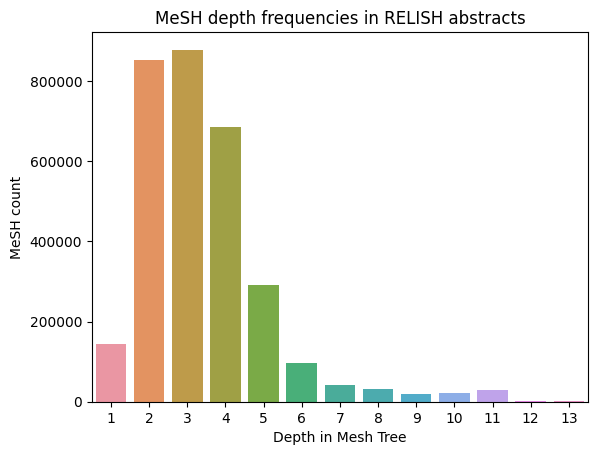

In [8]:
i = 0
Depth_vs_freq = {}
for node_id in big_G.nodes:
    if(node_id in big_G_nodes and MeSH_cnt[node_id] != 0):
        dpth = big_G.nodes[node_id]["Depth"]
        freq = big_G.nodes[node_id]["Frequency_Pubmed"]
        if(dpth in Depth_vs_freq): Depth_vs_freq[dpth] += freq
        else: Depth_vs_freq[dpth] = freq        
        i+=1
    # if(i == 20): break

sortedKeys = list(Depth_vs_freq.keys())
sortedKeys.sort()
Depth_vs_freq = {i: Depth_vs_freq[i] for i in sortedKeys}

df_Depth_vs_freq = pd.DataFrame()
df_Depth_vs_freq['Depth in Mesh Tree'] = list(Depth_vs_freq.keys())
df_Depth_vs_freq['MeSH count'] = list(Depth_vs_freq.values())

print(df_Depth_vs_freq)
sns.barplot(df_Depth_vs_freq, x="Depth in Mesh Tree", y="MeSH count").set(title='Unique MeSH depth frequencies in RELISH abstracts')